In [1]:
# ============================================================
# Notebook setup
# ============================================================

#%load_ext autoreload
#%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

2023-07-05 10:27:09.274524: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 10:27:09.312148: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 10:27:09.312898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 10:27:10.045554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


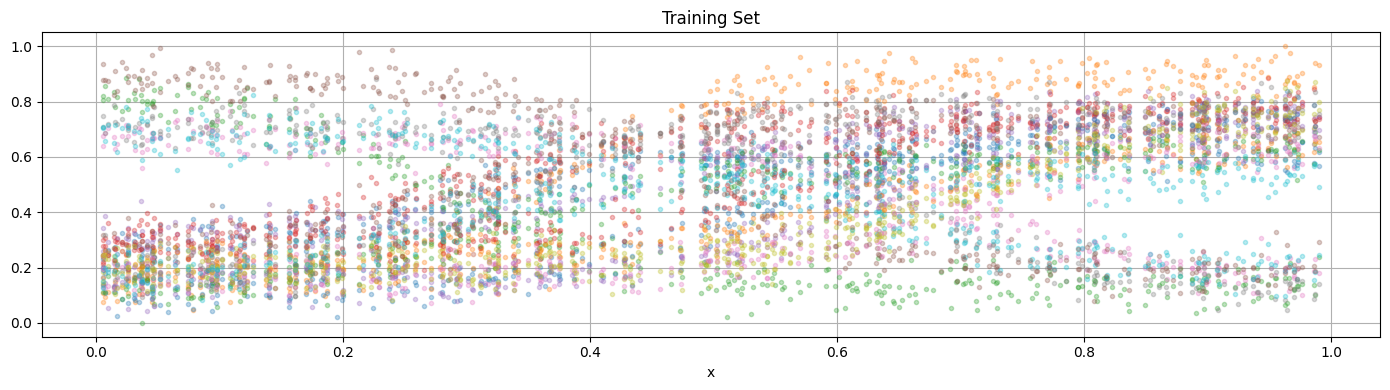

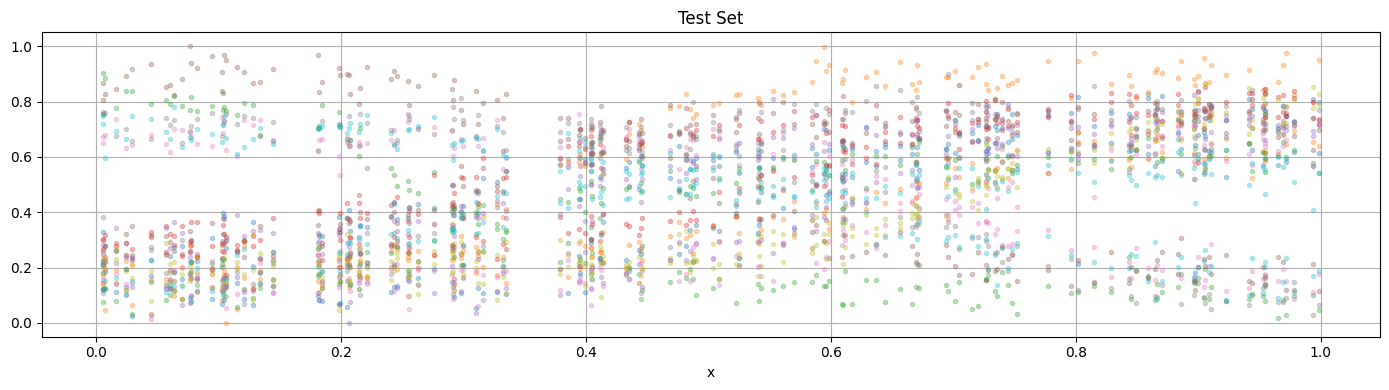

#Examples: 350 (training), 150 (test)


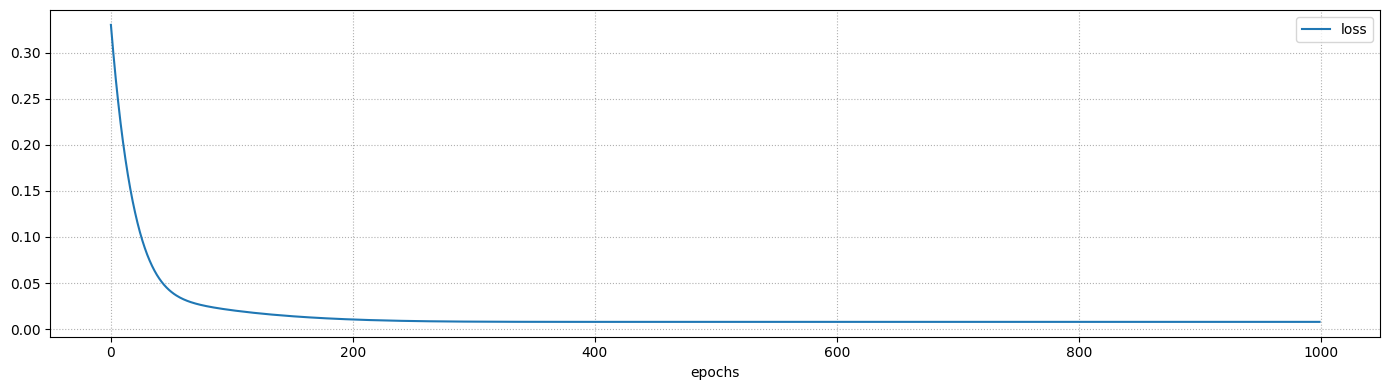

Final loss: 0.0078 (training)
R2: 0.82, MAE: 0.073, RMSE: 0.09 (training)
R2: 0.81, MAE: 0.077, RMSE: 0.09 (test)


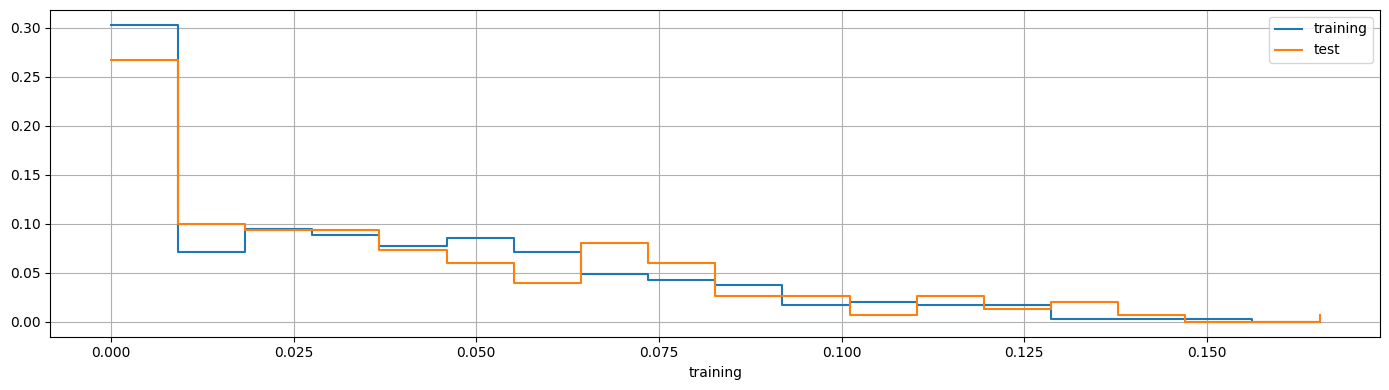

Mean: 0.037 (training), 0.041 (test)


In [2]:
import imp
imp.reload(util)

nitems = 20
nsamples_tr = 350
nsamples_ts = 150
nsamples_per_point_tr = 1
nsamples_per_point_ts = 1
noise_scale = 0.15
noise_type = 'normal'
noise_scale_type = 'absolute'
rel_req = 0.5

seed = 42

data_tr = util.generate_costs(nsamples_tr, nitems, seed=seed, sampling_seed=seed,
                              noise_scale=noise_scale, noise_type=noise_type, noise_scale_type=noise_scale_type,
                             nsamples_per_point=nsamples_per_point_tr)
data_ts = util.generate_costs(nsamples_ts, nitems, seed=seed, sampling_seed=seed+1,
                              noise_scale=noise_scale, noise_type=noise_type, noise_scale_type=noise_scale_type,
                             nsamples_per_point=nsamples_per_point_ts)

util.plot_df_cols(data_tr, figsize=figsize, title='Training Set', scatter=True)
util.plot_df_cols(data_ts, figsize=figsize, title='Test Set', scatter=True)

print(f'#Examples: {len(data_tr)} (training), {len(data_ts)} (test)')

tr_in, tr_out = data_tr.index.values, data_tr.values
ts_in, ts_out = data_ts.index.values, data_ts.values

pfl = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[], name='PFL', output_activation='linear')
history = util.train_nn_model(pfl, tr_in, tr_out, epochs=1000, loss='mse', validation_split=0)
util.plot_training_history(history, figsize=figsize)

r2, mae, rmse = util.get_ml_metrics(pfl, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(pfl, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')




prb = util.generate_problem(nitems=nitems, rel_req=rel_req, seed=seed)

r_tr = util.compute_regret(prb, pfl, tr_in, tr_out)
r_ts = util.compute_regret(prb, pfl, ts_in, ts_out)
util.plot_histogram(r_tr, figsize=figsize, label='training', data2=r_ts, label2='test', print_mean=True)

## SPO+

CPU times: user 2min 43s, sys: 10min 44s, total: 13min 27s
Wall time: 1min 23s


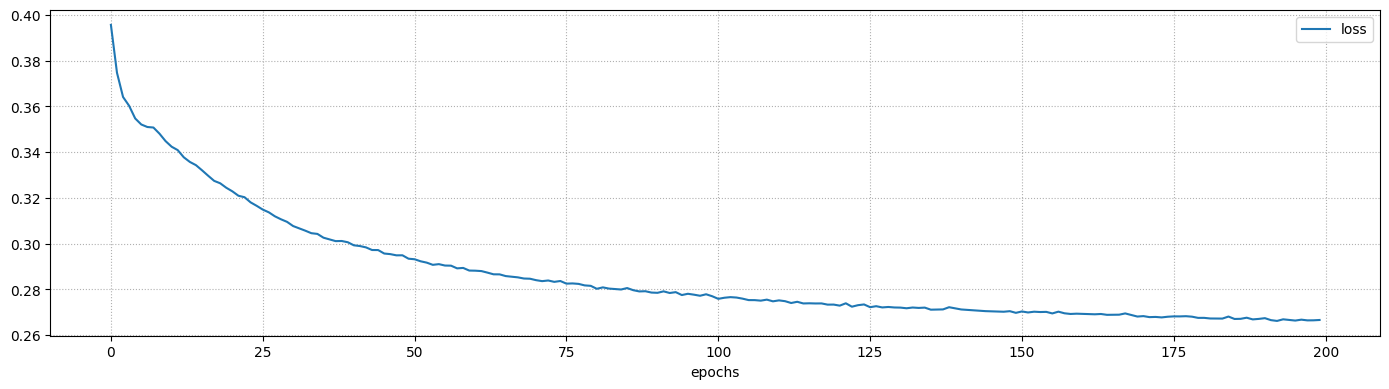

Final loss: 0.2666 (training)
R2: 0.66, MAE: 0.091, RMSE: 0.13 (training)
R2: 0.67, MAE: 0.092, RMSE: 0.13 (test)


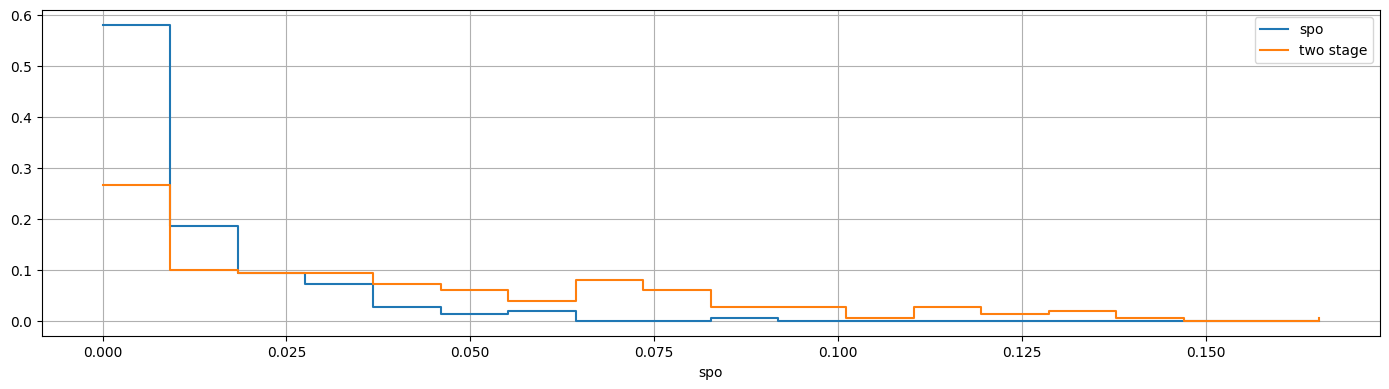

Mean: 0.011 (spo), 0.041 (two stage)


In [4]:
import imp
imp.reload(util)

spo = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, recompute_chance=0.05,
                                   hidden=[], name='spo_cache', output_activation='linear',
                                  loss_type='spo')

util.transfer_weights_to_dfl_model(pfl, spo)

%time history = util.train_dfl_model(spo, tr_in, tr_out, epochs=200, verbose=0, validation_split=0)
util.plot_training_history(history, figsize=figsize)

r2, mae, rmse = util.get_ml_metrics(spo, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(spo, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

r_ts_spo = util.compute_regret(prb, spo, ts_in, ts_out)
util.plot_histogram(r_ts_spo, figsize=figsize, label='spo', data2=r_ts, label2='two stage', print_mean=True)

## Self-Contrastive + Regret

CPU times: user 4min 20s, sys: 15min 53s, total: 20min 14s
Wall time: 3min 23s


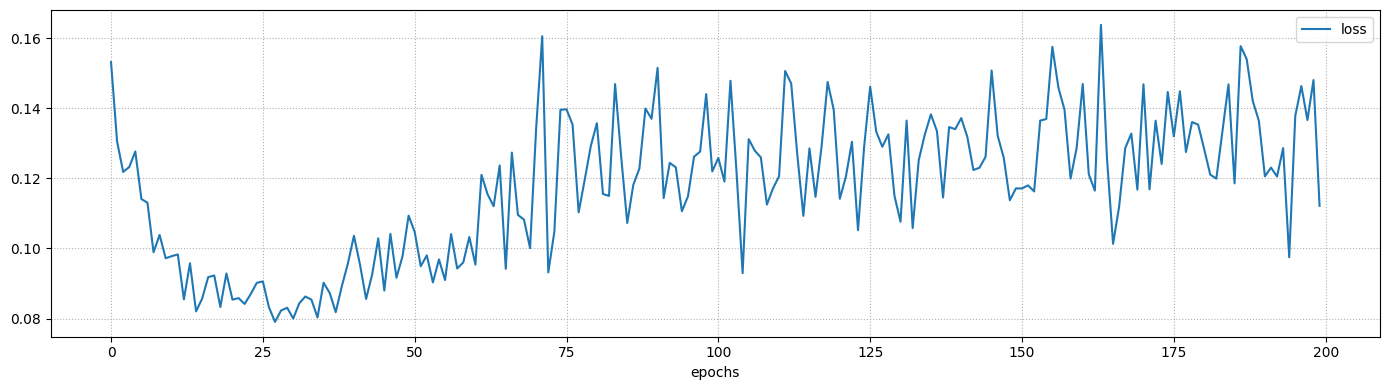

Final loss: 0.1122 (training)
R2: 0.60, MAE: 0.1, RMSE: 0.13 (training)
R2: 0.61, MAE: 0.11, RMSE: 0.13 (test)


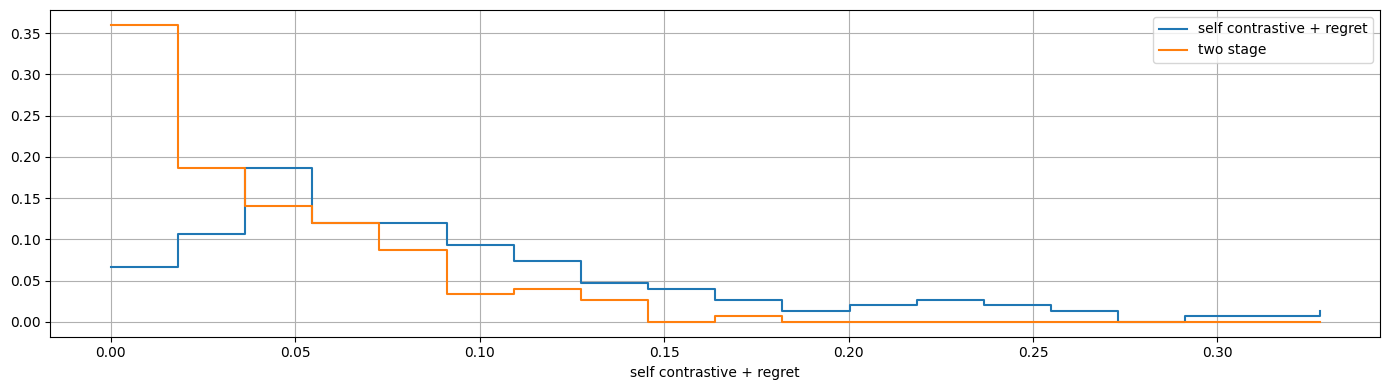

Mean: 0.094 (self contrastive + regret), 0.041 (two stage)


In [5]:
scr = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, recompute_chance=0.05,
                                   hidden=[], name='scr_cache', output_activation='linear')

util.transfer_weights_to_dfl_model(pfl, scr)

%time history = util.train_dfl_model(scr, tr_in, tr_out, epochs=200, verbose=0, validation_split=0)
util.plot_training_history(history, figsize=figsize)

r2, mae, rmse = util.get_ml_metrics(scr, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(scr, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

r_ts_src = util.compute_regret(prb, scr, ts_in, ts_out)
util.plot_histogram(r_ts_src, figsize=figsize, label='self contrastive + regret', data2=r_ts, label2='two stage', print_mean=True)

## Self-contrastive

CPU times: user 2min 41s, sys: 10min 12s, total: 12min 53s
Wall time: 1min 19s


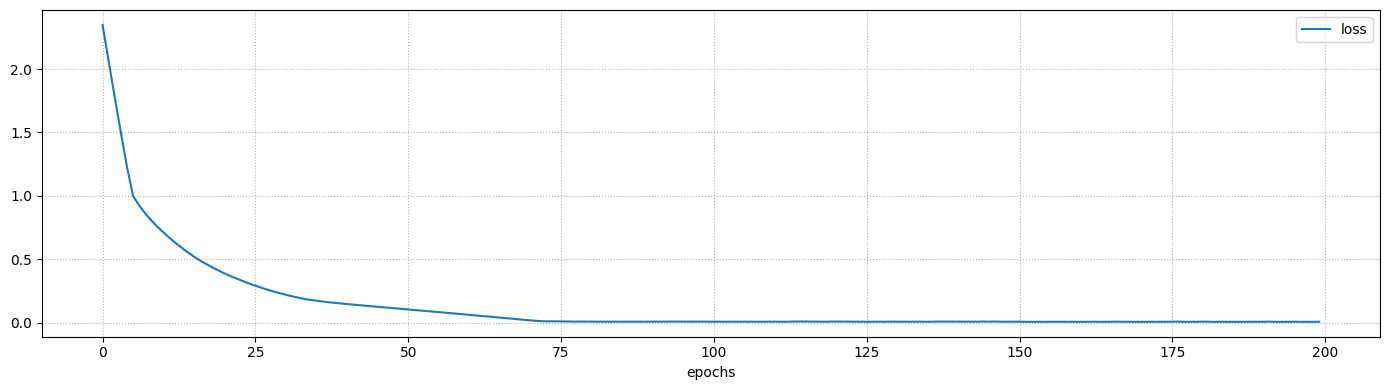

Final loss: 0.0078 (training)


In [88]:
sc_late = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, recompute_chance=0.05,
                                    hidden=[], name='sc_cache', output_activation='linear_normalized',
                                        loss_type='sc')
%time history = util.train_dfl_model(sc_late, tr_in, tr_out, epochs=200, verbose=0, validation_split=0)
util.plot_training_history(history, figsize=figsize)

In [89]:
r2, mae, rmse = util.get_ml_metrics(sc_late, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(sc_late, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: -3.64, MAE: 0.41, RMSE: 0.48 (training)
R2: -3.82, MAE: 0.42, RMSE: 0.48 (test)


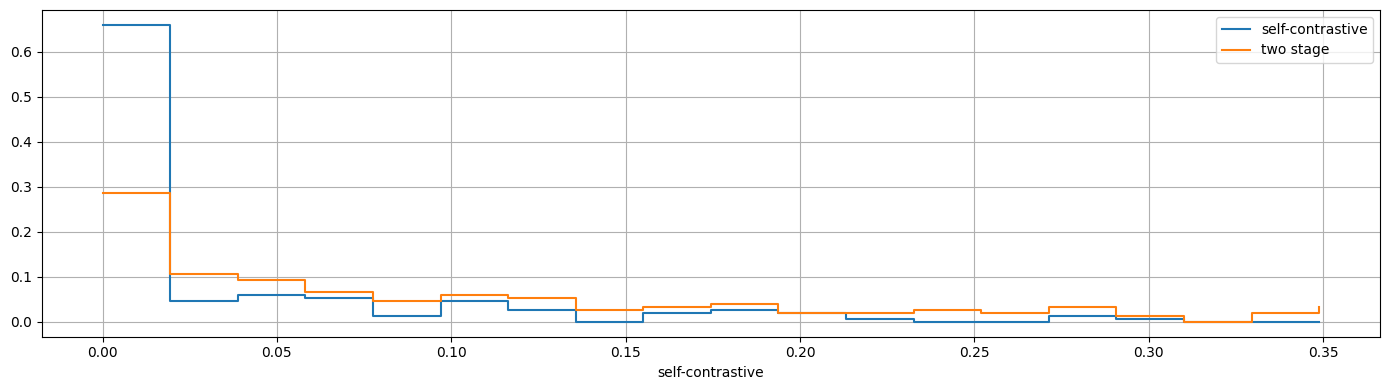

Mean: 0.038 (self-contrastive), 0.099 (two stage)


In [90]:
r_ts_sc_late = util.compute_regret(prb, sc_late, ts_in, ts_out)
util.plot_histogram(r_ts_sc_late, figsize=figsize, label='self-contrastive', data2=r_ts, label2='two stage', print_mean=True)